# Adavanced Scikit-learn for TMVA Users

*This notebook first appeared as a [blog post](//betatim.github.io/posts/sklearn-for-TMVA-users) on [Tim Head](//betatim.github.io)'s blog.*

*License: [MIT](http://opensource.org/licenses/MIT)*

*(C) 2015, Tim Head.*
*Feel free to use, distribute, and modify with the above attribution.*

Particle physics is full of machine learning. It powered the discovery of the [Higgs boson](//http://en.wikipedia.org/wiki/Higgs_boson) and it is used to decide which data an experiment should record. As well as in many other analyses.

This is a follow up to my previous post [scikit-learn for TMVA users](/posts/sklearn-for-TMVA-users/) which covers how to do the most common things in TMVA with scikit-learn. This post will go beyond TMVA and show off features of scikit-learn which are not easily available in TMVA. You should read this more as a reference than a tutorial, most topics have links to more documentation or other tutorials.

Thanks again to [Gilles Louppe](//twitter.com/glouppe) for all the advice and help!

The post covers:

* cross validation to estimate classifier performance
* grid search and cross validation to optimise hyper-parameters
* learning curves
* validation curves
* the unfair advantage

As usual, first some imports:

In [1]:
%matplotlib inline

import random

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score

## Loading ROOT Trees

Data comes first, the excellent [`root_numpy`](//rootpy.github.io/root_numpy/) library makes it easy to read your data stored in a ROOT TTree. Each call to `root2array` will create a 2D array which contains one row per event, and one column representing each branch you want to use.

You can download the dataset used here from [figshare](//figshare.com):
 * [HIGGS-background.root](http://figshare.com/articles/HIGGS_background/1314900)
 * [HIGGS-signal.root](http://figshare.com/articles/HIGGS/1314899)
 
The events are derived from the much larger [HIGGS](http://archive.ics.uci.edu/ml/datasets/HIGGS) dataset. A description of the variables can be found there as well.

The first thing to do is split your data into a development and an evaluation set. It is
important to not peek at the evaluation set before you are done with optimising
your classifier, otherwise you will not get an unbiased estimate of the performance
from it. We do not split the development set into a training and testing set, keep
reading for why.

In [2]:
from root_numpy import root2array, rec2array
from sklearn.cross_validation import train_test_split


branch_names = """lepton pT, lepton eta, lepton phi, missing energy magnitude,
missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt,
jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag,
jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb,
m_wwbb""".split(",")
branch_names = [c.strip() for c in branch_names]
branch_names = (b.replace(" ", "_") for b in branch_names)
branch_names = list(b.replace("-", "_") for b in branch_names)

signal = root2array("/tmp/HIGGS_signal.root",
                    "tree",
                    branch_names)
signal = rec2array(signal)

backgr = root2array("/tmp/HIGGS_background.root",
                    "tree",
                    branch_names)
backgr = rec2array(backgr)

# for sklearn data is usually organised
# into one 2D array of shape (n_samples x n_features)
# containing all the data and one array of categories
# of length n_samples
X = np.concatenate((signal, backgr))
y = np.concatenate((np.ones(signal.shape[0]), np.zeros(backgr.shape[0])))

# set aside an evaluation sample
# We artificially limit ourselves
# to a small subset of the available
# samples. This speeds things up and
# makes it easier to illustrate things
# like over-fitting. In real life you
# would not do this.
X_dev,X_eval, y_dev,y_eval = train_test_split(X, y,
                                              train_size=20000,
                                              test_size=10000,
                                              random_state=42)

## Bias and Variance

A brief detour to jargon land: bias and variance, the bias-variance tradeoff and similar
are the terms used to describe the two components that make up the error of a classifier.
[Scott Fortman-Roe](//scott.fortmann-roe.com/) has a nice [illustrated guide](//scott.fortmann-roe.com/docs/BiasVariance.html). In short: a biased model will on average be far away from the truth, a model with high variance will have a large spread, but might be right on average.

The below picture is a pretty good visualisation:

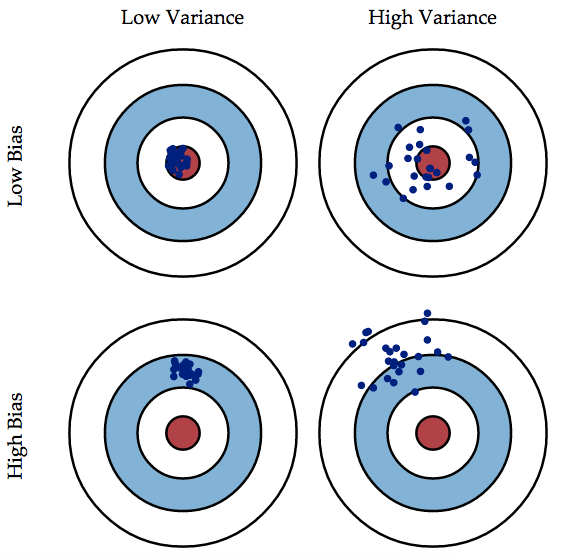

In [3]:
from IPython.display import Image
Image('../../images/bias-variance.png')

A classifier's error will be composed of a term due to bias and one due to variance.

A model which is too simple will usually have a high bias, this is referred to as
under-fitting. A model which is too complicated will usually have a high variance,
it gives very different answers for different unseen datasets. This is referred to
as over-fitting.

The astro-ml guide has a [nice explanation using poynomials and house prices](//www.astroml.org/sklearn_tutorial/practical.html#bias-variance-over-fitting-and-under-fitting).

## Cross-validation

In the process of choosing your classifier and setting its hyper-parameters you
normally use a training and testing set of events. However if you want to optimise
your hyper-parameters you run the risk of over-fitting your test set by changing
the hyper-parameters until you find the set which performs best on the testing set.

Cross-validation (CV) offers a way out! In its most basic form it is called
_k-fold_ CV. You split your development set into $k$ samples. Then use $k-1$ 
of the sub-samples for training and the other sample for testing. For example
if you split your development set into three parts (0, 1, 2) you would get
three estimates of the classifier's performance:

* train on 0, 1 and evaluate on 2
* train on 1, 2 and evaluate on 0
* train on 0, 2 and evaluate on 1

Then average the performance measure from each of the iterations, this is what
you end up reporting. It also allows you to compute the standard deviation of
your performance metric, so you get an uncertainty as well.

The scikit-learn documentation has a nice guide on [Cross-validation: evaluating estimator performance](//scikit-learn.org/stable/modules/cross_validation.html).

The simplest way to use CV in `scikit-learn` is the `cross_val_score`
function:

In [5]:
from sklearn import cross_validation
from sklearn.ensemble import GradientBoostingClassifier


gbt = GradientBoostingClassifier(n_estimators=200,
                                 max_depth=1,
                                 subsample=0.5,
                                 max_features=0.5,
                                 learning_rate=0.02)

scores = cross_validation.cross_val_score(gbt,
                                          X_dev, y_dev,
                                          scoring="roc_auc",
                                          n_jobs=6,
                                          cv=3)

In [6]:
print "Accuracy: %0.5f (+/- %0.5f)"%(scores.mean(), scores.std())

Accuracy: 0.71285 (+/- 0.00805)


Once you have mastered CV by itself, move on to using it to optimise your classifier's hyper-parameters.

## Optimising Hyper-parameters

Each machine learning technique has a set of parameters which are not learnt from the training data. For example the number of trees in your ensemble of decision trees, or how deep each tree should be. These are called hyper-parameters. The best value for each of them depends on the particular learning problem you are trying to solve. Therefore it makes sense to try and find the best set of hyper-parameters

Once you are familiar with CV you will want to use it to find the best set of hyper-parameters for your learning problem. The easiest way to do that is to perform a [grid search](//scikit-learn.org/stable/modules/grid_search.html) over the parameter space. In `scikit-learn` this functionality is provided by `GridSearchCV`:

In [7]:
from sklearn import grid_search


# Perform grid search over all combinations
# of these hyper-parameters
param_grid = {"n_estimators": [50,200,400,1000],
              "max_depth": [1, 3, 8],
              'learning_rate': [0.1, 0.2, 1.]}

clf = grid_search.GridSearchCV(gbt,
                               param_grid,
                               cv=3,
                               scoring='roc_auc',
                               n_jobs=8)
_ = clf.fit(X_dev, y_dev)

In [8]:
print "Best parameter set found on development set:"
print
print clf.best_estimator_
print
print "Grid scores on a subset of the development set:"
print
for params, mean_score, scores in clf.grid_scores_:
    print "%0.4f (+/-%0.04f) for %r"%(mean_score, scores.std(), params)
print
print "With the model trained on the full development set:"

y_true, y_pred = y_dev, clf.decision_function(X_dev)
print "  It scores %0.4f on the full development set"%roc_auc_score(y_true, y_pred)
y_true, y_pred = y_eval, clf.decision_function(X_eval)
print "  It scores %0.4f on the full evaluation set"%roc_auc_score(y_true, y_pred)

Best parameter set found on development set:

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=0.5, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2, n_estimators=200,
              random_state=None, subsample=0.5, verbose=0,
              warm_start=False)

Grid scores on a subset of the development set:

0.7151 (+/-0.0078) for {'n_estimators': 50, 'learning_rate': 0.1, 'max_depth': 1}
0.7491 (+/-0.0044) for {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 1}
0.7547 (+/-0.0035) for {'n_estimators': 400, 'learning_rate': 0.1, 'max_depth': 1}
0.7550 (+/-0.0037) for {'n_estimators': 1000, 'learning_rate': 0.1, 'max_depth': 1}
0.7674 (+/-0.0053) for {'n_estimators': 50, 'learning_rate': 0.1, 'max_depth': 3}
0.7731 (+/-0.0024) for {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3}
0.7716 (+/-0.0029) for {'n_estimators': 400, 'learning_rate': 0.1, 'max_depth': 3}
0.7620 (+/-0.0045) f

The first thing to notice is how much the performance varies across hyper-parameters. The next thing to note is that the performance estimated as part of the grid search (0.7730)
is different from the performance (0.7835) evaluated on the never seen evaluation set.
In this case the classifier actually performs better than in the grid search. You can
also see that the performance measured on the training set is biased upwards (0.8235).

For a large number of hyper-parameter combinations it will take a long time to evaluate them all. [`RandomizedSearchCV`](//scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-optimization) samples from distributions of the hyper-parameters and evaluates random points. This can be quicker.


## Validation curves

Another useful tool for picking your final model are validation curves. It can help you answer the question: should my model be more complex?

A larger number of boosting iterations usually means a more complex classifier. We can evaluate the performance of our classifier after each boosting iteration and compare the training and testing score.

In order to visualise the small changes in the score as we get to higher boosting iterations we plot 1-score. This means that smaller is better.

To illustrate how differently the same type of classifier can behave for different hyper-parameters we will train four different ones varying the `max_depth` and `learning_rate` parameter.

In [113]:
# Split development set into a train and test sample
X_train,X_test, y_train,y_test = train_test_split(X_dev, y_dev,
                                                  test_size=0.33, random_state=4685)

clfs = []
params = ((1.,1), (1.,4),
          (0.2,1), (0.2,4))

for learn,depth in params:
    gbt_clf = GradientBoostingClassifier(max_depth=depth,
                                         learning_rate=learn,
                                         n_estimators=200)
    gbt_clf.fit(X_train, y_train)
    clfs.append(gbt_clf)

The `validation_curve` function will plot the area under the ROC after each boosting iteration for each of the classifiers. The solid line shows the performance on the testing sample and the dashed line shows the performance on the training sample.

In almost all cases the performance on the training sample keeps improving as we increase the number of boosting iterations.

In [128]:
def validation_curve(clfs, train, test):
    X_test, y_test = test
    X_train, y_train = train
    
    for n,clf in enumerate(clfs):
        test_score = np.empty(len(clf.estimators_))
        train_score = np.empty(len(clf.estimators_))

        for i, pred in enumerate(clf.staged_decision_function(X_test)):
            test_score[i] = 1-roc_auc_score(y_test, pred)

        for i, pred in enumerate(clf.staged_decision_function(X_train)):
            train_score[i] = 1-roc_auc_score(y_train, pred)

        best_iter = np.argmin(test_score)
        learn = clf.get_params()['learning_rate']
        depth = clf.get_params()['max_depth']
        test_line = plt.plot(test_score,
                             label='learn=%.1f depth=%i (%.2f)'%(learn,depth,
                                                                 test_score[best_iter]))

        colour = test_line[-1].get_color()
        plt.plot(train_score, '--', color=colour)
        
        plt.xlabel("Number of boosting iterations")
        plt.ylabel("1 - area under ROC")
        plt.axvline(x=best_iter, color=colour)
        
    plt.legend(loc='best')

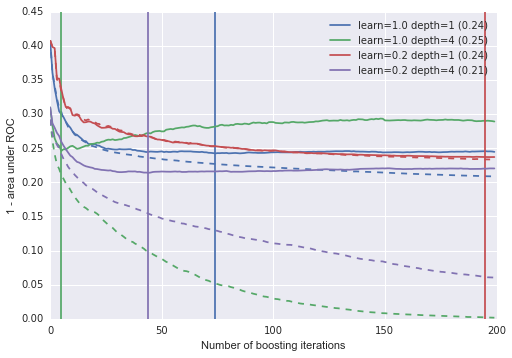

In [129]:
validation_curve(clfs,
                 (X_train,y_train),
                 (X_test,y_test))

The vertical lines mark the boosting iteration at which a classifier achieves its best performance as measured on the testing set.

We can see that the training score keeps improving as the model becomes more complex. The score on the testing set however eventually flattens off or starts getting worse. The classifier with `learning_rate=1.0` and `max_depth=4` reaches its best performance after a very small number of boosting iterations. Its training score keeps improving until it reaches zero at about 200 boosting iterations.

Comparing classifiers with the same `max_depth` we can see that those with lower learning rate need more boosting iterations to reach the same performance as those with larger learning rate. However they can also converge to an overall higher score, making them the better classifier.


## Learning curves

To answer the question of whether more training events would improve the performance we can evaluate the performance of a classifier when trained on a increasingly larger fraction of the test set. Broadly speaking, if the train and test score have plateaued/converged there is not much to
be gained by adding more training examples. If the training error stays somewhat constant with
training size and there is a large gap to the testing score, then there might be gains to be made by increasing the number of training events.

Below I show the learning curves for four different classifiers. The first one is a very simple one, only 50 decisions stumps. The other three are the ones used as examples for the validation curves above.

In [173]:
from sklearn.learning_curve import learning_curve

# Taken more or less straight from
# http://scikit-learn.org/stable/auto_examples/plot_learning_curve.html
def plot_learning_curve(estimator, title, X, y, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5),
                        scoring=None, ax=None, xlabel=True):
    if ax is None:
        plt.figure()
        ax.title(title)
    
    if xlabel:
        ax.set_xlabel("Training examples")
        
    ax.set_ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator,
                                                            X, y,
                                                            cv=cv,
                                                            n_jobs=n_jobs,
                                                            train_sizes=train_sizes,
                                                            scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    ax.set_ylim([0.65, 1.0])
    return plt

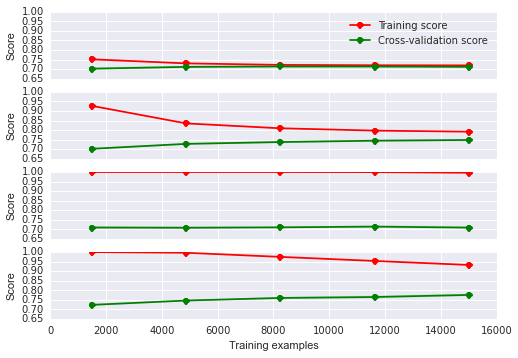

In [174]:
simpleton = GradientBoostingClassifier(max_depth=1,
                                       learning_rate=0.1,
                                       n_estimators=50)
classifiers = [simpleton, clfs[0], clfs[1], clfs[3]]

fig, axes = plt.subplots(nrows=len(classifiers), sharex=True)

for clf, ax in zip(classifiers, axes):  
    plot_learning_curve(clf,
                        "Learning curves",
                        X_dev, y_dev,
                        scoring='roc_auc',
                        n_jobs=7, cv=4,
                        ax=ax, xlabel=False)
    
axes[0].legend(loc="best")
axes[-1].set_xlabel("Training examples")

The behaviour varies quite a lot. For the first classifier it is clear that adding more training examples will not improve performance. The classifier has plateaued at a score of around 0.72. The second classifier is a more complex model than the first, and it converges on a higher score of nearly 0.75. Making the model more complex was the right choice as it allowed it to achieve a higher score.

The third model achieves a perfect score on the training set for all sizes. However there is a large gap between the test and training score. The model has enough parameters to capture the complexity of the training data, however it does not seem to generalise well. On unseen data it performs no better than the simplest model.

The fourth model has the same `max_depth` as the third model, however it has slower learning rate. It does not achieve a perfect score on the training set for all sizes, however, it generalises much better to unseen data. It achieves the highest test score of all models. In addition the test score increases every time the training set is enlarged. Adding more samples will probably improve performance in this case.

Thus you can bring the training and testing curves closer together by adding more training points, but you can increase the score only by adding complexity to the model.

A simple model will converge early and show that the score on the training and testing set is the same. This usually means you want to make your model a little more complex.

If there is a large gap between the training and testing set you want to add more training events to your model. More training events will reduce the difference between the performance on the two sets.

Training a model which has already converged with more samples will not improve the performance.


## The Unfair Advantage

Unlike in the real world we can check our assumptions about adding more training samples! The original dataset contains 1million samples of which we used only a tiny fraction so far. Usually obtaining more training examples means a lot of hard work or spending more money. This is the unfair advantage of simulated data!

Below we roughly double the size of the training data. As predicted the performance of both classifiers improves with more data.

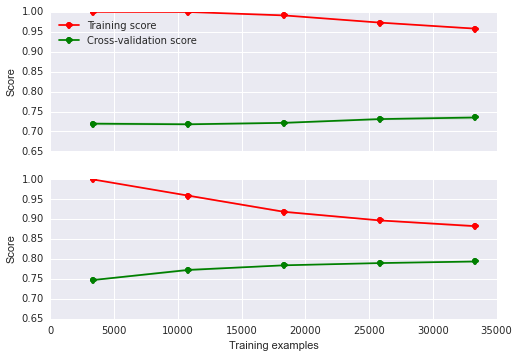

In [177]:
X_dev2,X_eval2, y_dev2,y_eval2 = train_test_split(X, y,
                                                  test_size=0.4,
                                                  random_state=42)

classifiers = [clfs[1], clfs[3]]

fig, axes = plt.subplots(nrows=len(classifiers), sharex=True)

for clf, ax in zip(classifiers, axes):  
    plot_learning_curve(clf,
                        "Learning curves",
                        X_dev2[:50000], y_dev2[:50000],
                        scoring='roc_auc',
                        n_jobs=7, cv=3,
                        ax=ax, xlabel=False)
    
axes[0].legend(loc="best")
axes[-1].set_xlabel("Training examples")

This is the end of the second part of [scikit-learn for TMVA users](/posts/advanced-sklearn-for-TMVA/). Thank you for reading.

If you find a mistake or want to tell me something else get in touch on twitter @[betatim](//twitter.com/betatim)